In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import auc, classification_report, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
%matplotlib inline

### Data:
This dataset is the diabetes dataset from UCI data repository. The records were recorded from 1999 to 2008 according to the its source.

In [2]:
diabetes = pd.read_csv("data/diabetic_data.csv", engine="c")

In [3]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


From the dataframe, I have noticed that ? represents missing value. Therefore, I will be treating ? as null.

## Objective:
after glancing at the data, I wanted to explore how each attributes affect the readmission decision.

---

### Data Integrity Checks

In [4]:
diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
# lower case and underscore for column name
diabetes.columns = diabetes.columns.str.replace("-", "_").str.lower()

In [6]:
def check_most_freq(df):
    """This function checks each column and see
    which the most occured values in each column.
    This helps identify if a null value occupies most
    of a column. Which will be marked for deletion"""
    col = df.columns.tolist()
    miss_val = []
    for item in col:
        ele, count = np.unique(df[item], return_counts=True)
        argmax = np.argmax(count)
        miss_val.append((ele[argmax], "{}/{}".format(count[argmax],len(df))))
    return {k:v for k, v in zip(col, miss_val)}

In [7]:
check_most_freq(diabetes)

{'a1cresult': ('None', '84748/101766'),
 'acarbose': ('No', '101458/101766'),
 'acetohexamide': ('No', '101765/101766'),
 'admission_source_id': (7, '57494/101766'),
 'admission_type_id': (1, '53990/101766'),
 'age': ('[70-80)', '26068/101766'),
 'change': ('No', '54755/101766'),
 'chlorpropamide': ('No', '101680/101766'),
 'citoglipton': ('No', '101766/101766'),
 'diabetesmed': ('Yes', '78363/101766'),
 'diag_1': ('428', '6862/101766'),
 'diag_2': ('276', '6752/101766'),
 'diag_3': ('250', '11555/101766'),
 'discharge_disposition_id': (1, '60234/101766'),
 'encounter_id': (12522, '1/101766'),
 'examide': ('No', '101766/101766'),
 'gender': ('Female', '54708/101766'),
 'glimepiride': ('No', '96575/101766'),
 'glimepiride_pioglitazone': ('No', '101765/101766'),
 'glipizide': ('No', '89080/101766'),
 'glipizide_metformin': ('No', '101753/101766'),
 'glyburide': ('No', '91116/101766'),
 'glyburide_metformin': ('No', '101060/101766'),
 'insulin': ('No', '47383/101766'),
 'max_glu_serum': (

From the result above, I will remove weight, payer_code, and medical_specialty. These columns may (or may not) have high correlations with diabetes, but I am excluding them due to lack of data.

In [8]:
diabetes.drop(["weight", "payer_code", "medical_specialty"], axis=1, inplace=True)

Dropping encounter_id and patient_nbr because they are pretty much useless.

In [9]:
diabetes.drop(["encounter_id", "patient_nbr"], axis=1, inplace=True)

In [10]:
diabetes.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
# check datatype of each column
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null object
diag_2                      101766 non-null object
diag_3                      101766 non-null object
number_diagnoses            101766 non-null int64
max_glu_serum               10176

In [12]:
# split the columns into continuous and categorical for easier processing
cat_var = ['race','gender','age', 'diag_1','diag_2','diag_3',
           'max_glu_serum','a1cresult','metformin','repaglinide',
           'nateglinide','chlorpropamide','glimepiride','acetohexamide',
           'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone',
           'acarbose','miglitol','troglitazone','tolazamide','examide',
           'citoglipton','insulin','glyburide_metformin','glipizide_metformin',
           'glimepiride_pioglitazone','metformin_rosiglitazone','metformin_pioglitazone',
           'change','diabetesmed','readmitted']

cont_var = ['admission_type_id','discharge_disposition_id','admission_source_id',
            'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
            'number_outpatient','number_emergency','number_inpatient','number_diagnoses']

In [13]:
# lowercase all elements in dataframe
diabetes[cat_var] = diabetes[cat_var].applymap(lambda x: str(x).lower())

In [14]:
# make sure that the sum of the length of the two lists are equal to the total number of columns 
assert (len(cat_var) + len(cont_var) == len(diabetes.columns))

In [15]:
# change to the correct datatype
diabetes[cat_var] = diabetes[cat_var].apply(lambda x: x.astype("category"))
diabetes[cont_var] = diabetes[cont_var].apply(lambda x: x.astype("int"))

In [16]:
# confirming datatype has been changed
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
race                        101766 non-null category
gender                      101766 non-null category
age                         101766 non-null category
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null category
diag_2                      101766 non-null category
diag_3                      101766 non-null category
number_diagnoses            101766 non-null int64
max_glu_serum        

---
### EDA and Feature Engineering

First, I have to check if the data is balanced.

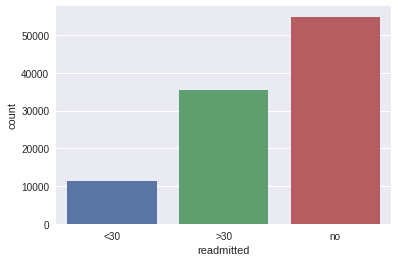

In [17]:
sns.countplot(data = diabetes, x = "readmitted");

Since we have 3 different classes and and are fairly imbalanced, it will be easier to combine $<30$ and $>30$ into readmitted. Therefore, the label becomes binary: yes and no

In [18]:
# creating binary classification rather than multiclass classification
# any readmission is converted to yes

diabetes.readmitted = diabetes.readmitted.map(lambda x: "yes" if x != "no" else x)
diabetes.readmitted = diabetes.readmitted.map(lambda x: x.lower())

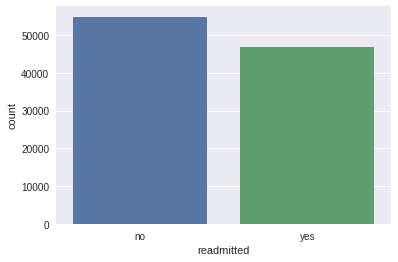

In [19]:
sns.countplot(data = diabetes, x = "readmitted");

##### dealing with null values

In [20]:
# replaced all ? to actual null
diabetes.replace("?", np.nan, inplace=True)

Age is the only ordinal categorical feature. The rest are nominal.

In [21]:
# creating a dictionary that maintains the order of age
age_key = {item:i+1 for item, i in zip(np.unique(diabetes.age), 
                                       [i for i in range(len(np.unique(diabetes.age)))])}
# applying that order and convert from categorical to continuous
diabetes.age = diabetes.age.map(lambda x: age_key[x])

Check the correlation between variables

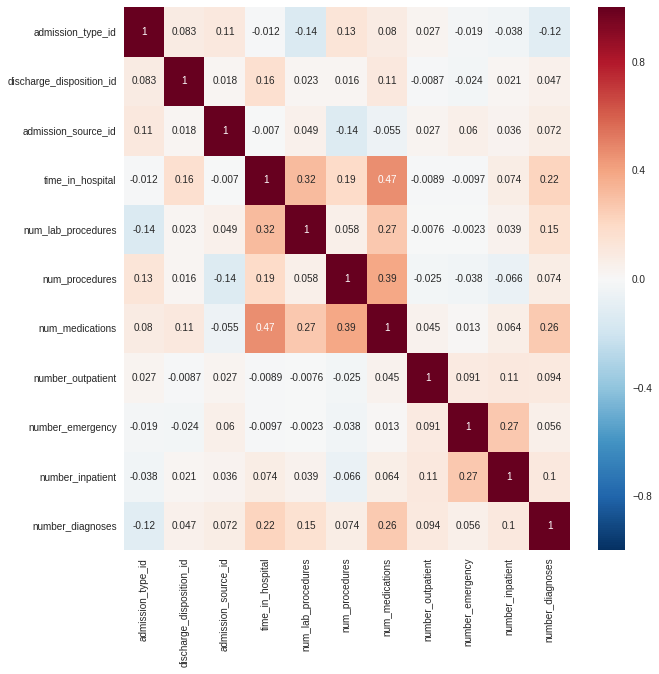

In [22]:
plt.figure(figsize=(10,10));
sns.heatmap(diabetes[cont_var].corr(), annot=True);

Looking at the correlation matrix, we don't see highly correlated variables (My threshold is above 0.6). Therefore, we don't have to worry about collinearity.

Since we are working with continuous data, we should check the nature of the data.

In [23]:
# checking the characteristics of our continuous variables
diabetes[cont_var].describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


From the tabe above, we can see that there are potential outliers present in some of the columns. I will have to work with the outliers and make sure they are treated with care.

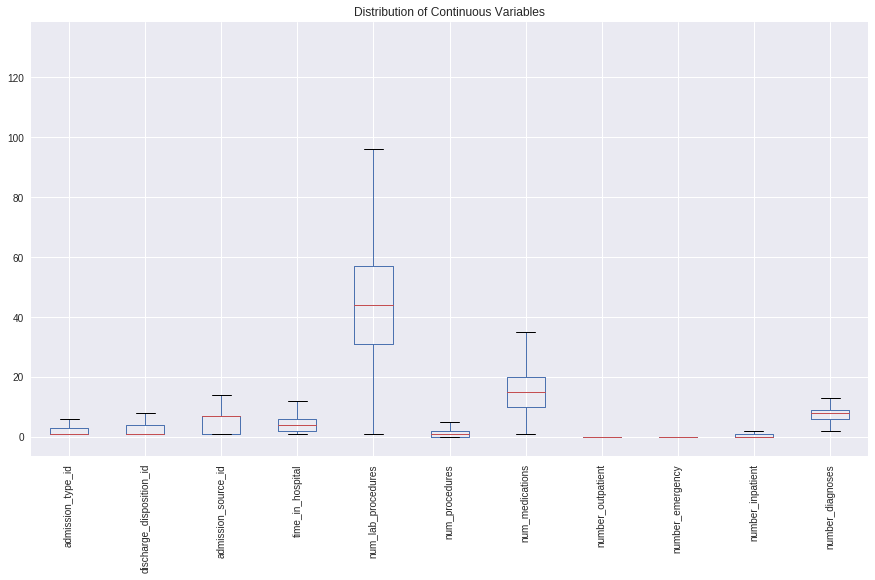

In [24]:
# graphing out to see the distribution and shape of each continuous variable
diabetes[cont_var].plot.box(figsize=(15,8));
plt.xticks(rotation = 90);
plt.title("Distribution of Continuous Variables");

Looking at the distribution of the continuous variables, we can see that we will need to standardize the distributions just in case if we go for dimension reduction/clustering. The technique I have chosen to standardize is to use RobustScaler because we have outliers in the dataset. Using IQR to scale will be a smarter choice.

In [25]:
# standardizing the variables with outlier
rs = RobustScaler()
diabetes[cont_var] = rs.fit_transform(diabetes[cont_var])

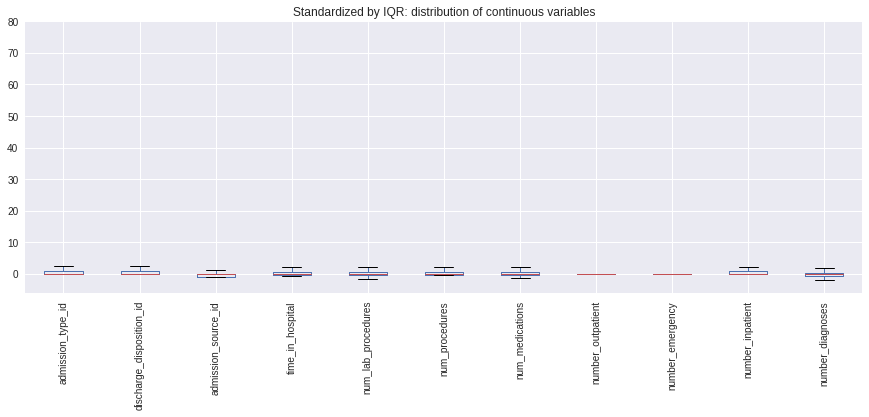

In [26]:
diabetes[cont_var].plot.box(figsize=(15,5));
plt.xticks(rotation = 90);
plt.title("Standardized by IQR: distribution of continuous variables");

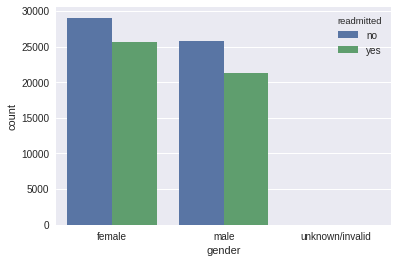

In [27]:
sns.countplot(data=diabetes, x='gender', hue='readmitted');

Seeing the gender counts, it might be better to drop the unknown/invalid records.

In [28]:
# replace unknown/invalid with null for easier imputation
diabetes.gender.replace("unknown/invalid", np.nan, inplace=True)

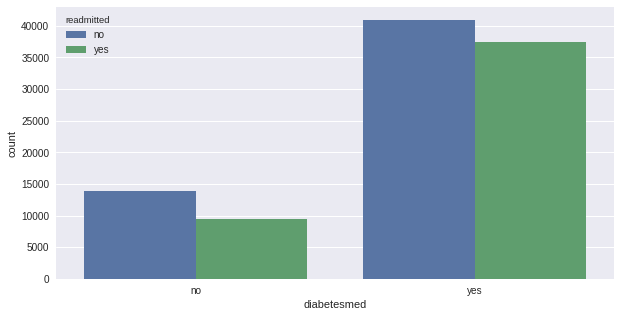

In [29]:
plt.figure(figsize=(10,5));
sns.countplot(data=diabetes, x='diabetesmed', hue='readmitted');

From the above plot, we can see more people gets readmitted when they are on diabetes medication.

In [30]:
# finding percent missing in the data
diabetes.apply(pd.isnull).apply(lambda x: len(x[x == True])/len(x) * 100).sort_values(ascending=False)

race                        2.233555
diag_3                      1.398306
diag_2                      0.351787
diag_1                      0.020636
gender                      0.002948
number_emergency            0.000000
metformin                   0.000000
a1cresult                   0.000000
max_glu_serum               0.000000
number_diagnoses            0.000000
number_inpatient            0.000000
number_outpatient           0.000000
nateglinide                 0.000000
num_medications             0.000000
num_procedures              0.000000
num_lab_procedures          0.000000
time_in_hospital            0.000000
admission_source_id         0.000000
discharge_disposition_id    0.000000
admission_type_id           0.000000
age                         0.000000
repaglinide                 0.000000
readmitted                  0.000000
diabetesmed                 0.000000
glimepiride                 0.000000
change                      0.000000
metformin_pioglitazone      0.000000
m

According to the missing data report produced above, race is missing 2.23% of the data and diag 1, 2, and 3 is missing 0.02%, 0.35%, and 1.39% respectively. Knowing this, I will drop the data since we are not missing too many records.

In [31]:
# comparing number of records before and after dropping null values
diabetes.shape, diabetes.dropna().shape

((101766, 45), (98052, 45))

In [32]:
# since we didn't lose too many records, I will be dropping the null values
diabetes.dropna(inplace=True)

In [33]:
# use LabelEncoder to convert all categorical values to numerical values
LE = LabelEncoder()
for var in cat_var:
    diabetes[var] = LE.fit_transform(diabetes[var])

In [54]:
diabetes[cont_var] = diabetes[cont_var].applymap(lambda x: abs(x))

# Modeling

In [55]:
# split the features from the label
features = diabetes.drop("readmitted", axis=1)
label = diabetes.readmitted

In [56]:
# train test split with 80% of the data as the training set
x_train, x_test, y_train, y_test = train_test_split(features, label, train_size = 0.8)

### Logistic Regression:
Modeling using logistic regression because its a very simple model and it works well for binary classification.

In [57]:
# with all features
logR = LogisticRegression(n_jobs=-1)
logR.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
logR.score(x_test, y_test)

0.6168476875223089

In [59]:
logR_pred = logR.predict(x_test)

In [60]:
print(classification_report(y_test, logR_pred))

             precision    recall  f1-score   support

          0       0.61      0.80      0.69     10505
          1       0.64      0.40      0.49      9106

avg / total       0.62      0.62      0.60     19611



the overall precision and recall scores were decent but not great. A 62% recall means that the model was only able to recall 62% of all the right answers and a 62% precision shows that the model needed to take many guesses before it can get to the right answers.

### ROC curve with AUC value for Logistic Regression

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, logR_pred)
area_u_curve = auc(fpr, tpr)

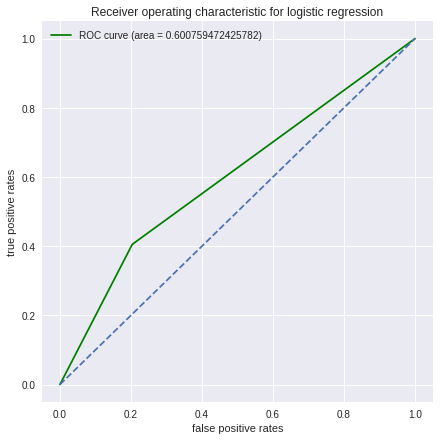

In [41]:
plt.figure(figsize=(7,7));
plt.plot(fpr, tpr, color='green', label='ROC curve (area = {})'.format(area_u_curve));
plt.plot([0,1], [0,1], linestyle='--');
plt.xlabel("false positive rates");
plt.ylabel("true positive rates");
plt.title('Receiver operating characteristic for logistic regression');
plt.legend(loc='upper left');

In the end, Logistic Regression has decent performance but not great. Therefore, I should probably try another classification model in the future. In the mean time, I will mess around with dimension reduction to see if I can understand the data better.

---

### PCA with clustering

In [77]:
# initialize PCA
pca = PCA(n_components=2)
reduced_feature = pca.fit_transform(features)

In [78]:
# initialize kmean with 2 cluster because I have 2 labels
km = KMeans(n_clusters=2, n_jobs=-1)

In [79]:
# fitting PCA-ed features into kmean
km.fit(reduced_feature)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [93]:
# create a dataframe for the predictions
km_pred = pd.DataFrame(km.predict(reduced_feature))

In [97]:
# mapping colors
km_cmap = {0:'red', 1:'green'}
km_pred['color'] = km_pred[0].replace(km_cmap)

In [106]:
import matplotlib.patches as mpatches

In [107]:
# mapping colors for legend
class_colours = ['red', 'green']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

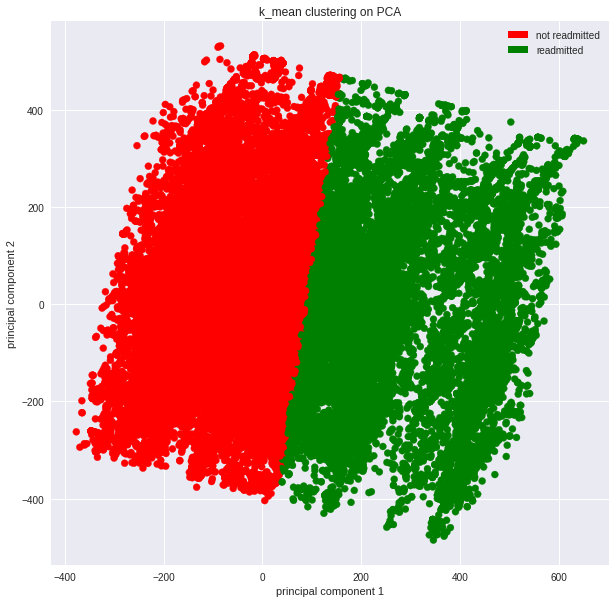

In [109]:
# plotting kmean result
classes = ['not readmitted', "readmitted"]
plt.figure(figsize=(10,10));
plt.scatter(reduced_feature[:, 0], 
            reduced_feature[:, 1], 
            c=km_pred.color);
plt.xlabel('principal component 1');
plt.ylabel('principal component 2');
plt.title('k_mean clustering on PCA');
plt.legend(recs, classes);

From the PCA, we can see that the labels are pretty much linearly separable but the decision boundary is a bit blur.

Not sure what to do after kmeans. Perhaps doing logistics regression on the PCA-ed data? any suggestions welcome. Thanks.